In [45]:
import pandas as pd

passengers = pd.read_csv("Data/train.csv")
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
x = passengers.drop(columns=["Survived"])
y = passengers["Survived"]

In [47]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


class SumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column1, column2):
        self.column1 = column1
        self.column2 = column2
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X[self.column1] + X[self.column2] + 1).to_frame()
    
    def get_feature_names_out(self, input_features=None):
        return ["FamilySize"]
    

class CutTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, bins, labels, name):
        self.bins = bins
        self.labels = labels
        self.column = column
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=[self.column])
        
        X[self.name] = pd.cut(X[self.column], bins=self.bins, labels=self.labels)
        return X[[self.name]].astype(str).to_numpy()

    def get_feature_names_out(self, input_features=None):
        return np.array([self.name])

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()
)

age_bins = [0, 3, 12, 20, 40, 60, 200]
age_labels = ["toddler", "child", "teen", "young-adult", "middle-adult", "senior"]
age_group_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    CutTransformer(column="Age", bins=age_bins, labels=age_labels, name="AgeGroup"),
    OneHotEncoder()
)

In [49]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, ["Sex", "Embarked", "Pclass"]),
    ("age_group", age_group_pipeline, ["Age"]),
    ("family_size", SumTransformer(column1="SibSp", column2="Parch"), ["SibSp", "Parch"]),
    ("dropper", "drop", ["Name", "Ticket", "SibSp", "Parch", "PassengerId", "Fare", "Cabin"]),
], remainder="passthrough")

In [50]:
x_preproc = preprocessing.fit_transform(x)
preprocessing.get_feature_names_out()

array(['cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S', 'cat__Pclass_1',
       'cat__Pclass_2', 'cat__Pclass_3', 'age_group__AgeGroup_child',
       'age_group__AgeGroup_middle-adult', 'age_group__AgeGroup_senior',
       'age_group__AgeGroup_teen', 'age_group__AgeGroup_toddler',
       'age_group__AgeGroup_young-adult', 'family_size__FamilySize'],
      dtype=object)

In [51]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from aquarel import load_theme


theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()


def plot_learning_curves(models_list: list, x, y, cv=5, size:int=10, n_columns:int=3):
    n_models = len(models_list)
    n_rows = (n_models + n_columns - 1) // n_columns

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, n_rows * 5))
    axs = np.array(axs).reshape(n_rows, n_columns)

    for i, (model, model_name) in enumerate(models_list):

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=x,
            y=y,
            train_sizes=np.linspace(0.1, 1.0, size),
            cv=cv,
            scoring='accuracy'
        )

        row, col = divmod(i, n_columns)
        ax = axs[row, col]
        ax.plot(train_sizes, train_scores.mean(axis=1), label="Train", marker="o")
        ax.plot(train_sizes, test_scores.mean(axis=1), label="Valid", marker="s")
        ax.set_title(model_name)
        ax.legend()
    
    fig.supxlabel("Samples in training set")
    fig.supylabel("Accuracy")

    # Remove the remainder empty subplots
    for i in range(n_models, n_rows * n_columns):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

In [52]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier


voting_clf = VotingClassifier(
    estimators=[
        ('svc', SVC()),
        ('rfc', RandomForestClassifier(max_features=5, max_depth=5)),
        ('lr', LogisticRegression()),
    ]
)

models_list = [
    (LogisticRegression(), "LogisticRegression"),
    (LogisticRegressionCV(), "LogisticRegressionCV"),
    (SGDClassifier(), "SGDClassifier"),
    (SVC(), "SVC"),
    (DecisionTreeClassifier(), "DecisionTreeClassifier"),
    (RandomForestClassifier(), "RandomForestClassifier"),
    (voting_clf, "VotingClassifier"),
    (GradientBoostingClassifier(), "GradientBoostingClassifier"),
    (HistGradientBoostingClassifier(), "HistGradientBoostingClassifier"),
]

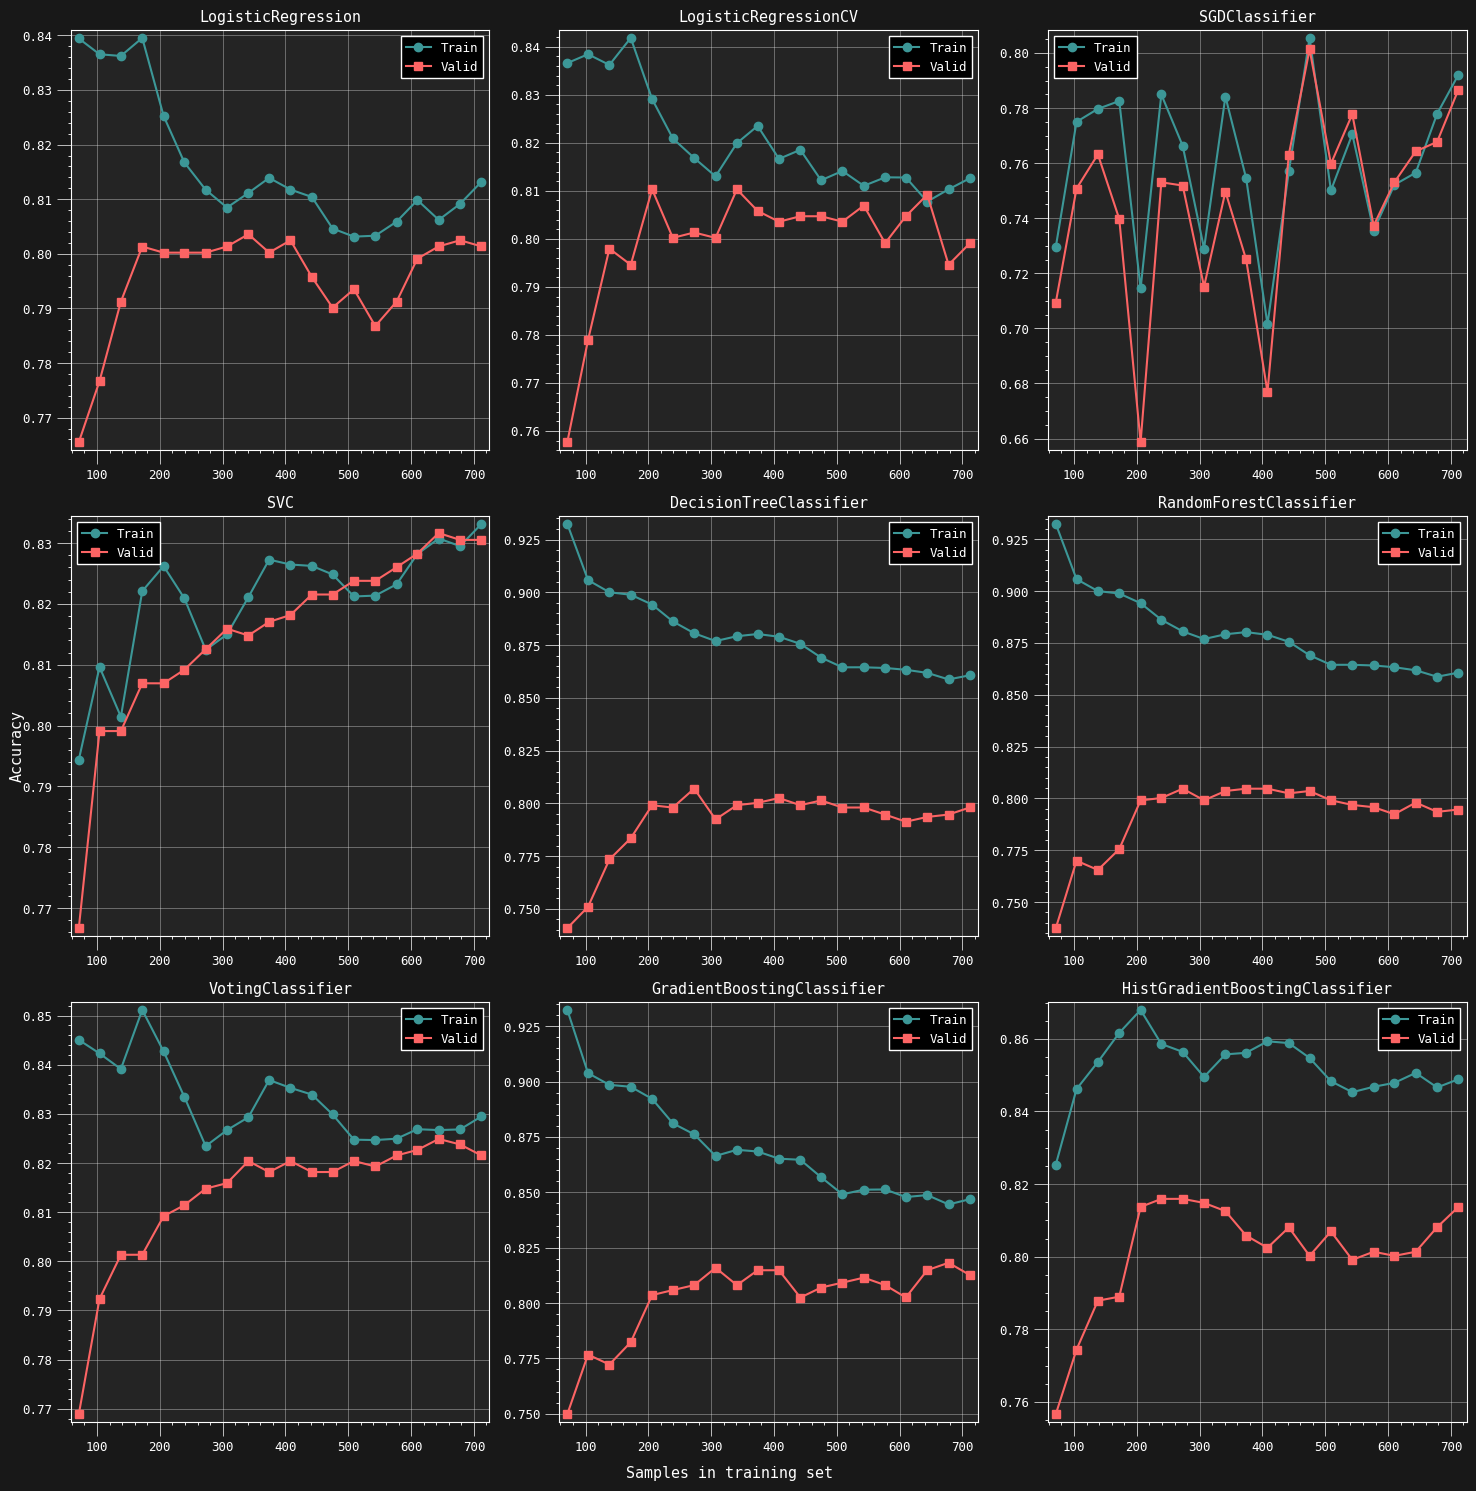

In [53]:
plot_learning_curves(models_list=models_list,
                     x=x_preproc,
                     y=y,
                     size=20)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


rfc_pipeline = make_pipeline(preprocessing, RandomForestClassifier())

param_dist_rfc = {
    'randomforestclassifier__max_depth': randint(low=2, high=20),
    'randomforestclassifier__max_leaf_nodes': randint(low=3, high=20),
    'randomforestclassifier__max_features': randint(low=2, high=20),
}

rfc_random_search = RandomizedSearchCV(
    estimator=rfc_pipeline,
    param_distributions=param_dist_rfc,
    n_iter=6,
    cv=3,
    scoring="accuracy"
)

rfc_random_search.fit(x, y)
rfc_random_search.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__max_features': 5,
 'randomforestclassifier__max_leaf_nodes': 15}

In [56]:
lr_pipeline = make_pipeline(preprocessing, LogisticRegression())

param_dist_lr = {
    'logisticregression__C': randint(low=1, high=100),
}

lr_random_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_dist_lr,
    n_iter=10,
    cv=3,
    scoring="accuracy"
)

lr_random_search.fit(x, y)
lr_random_search.best_params_

{'logisticregression__C': 54}

In [57]:
gbc_pipeline = make_pipeline(preprocessing, GradientBoostingClassifier())

param_dist_gbc = {
    'gradientboostingclassifier__max_depth': randint(low=2, high=20),
    'gradientboostingclassifier__max_features': randint(low=2, high=20),
    'gradientboostingclassifier__n_estimators': randint(low=20, high=200),
}

gbc_random_search = RandomizedSearchCV(
    estimator=gbc_pipeline,
    param_distributions=param_dist_gbc,
    n_iter=6,
    cv=3,
    scoring="accuracy"
)

gbc_random_search.fit(x, y)
gbc_random_search.best_params_

{'gradientboostingclassifier__max_depth': 12,
 'gradientboostingclassifier__max_features': 16,
 'gradientboostingclassifier__n_estimators': 60}

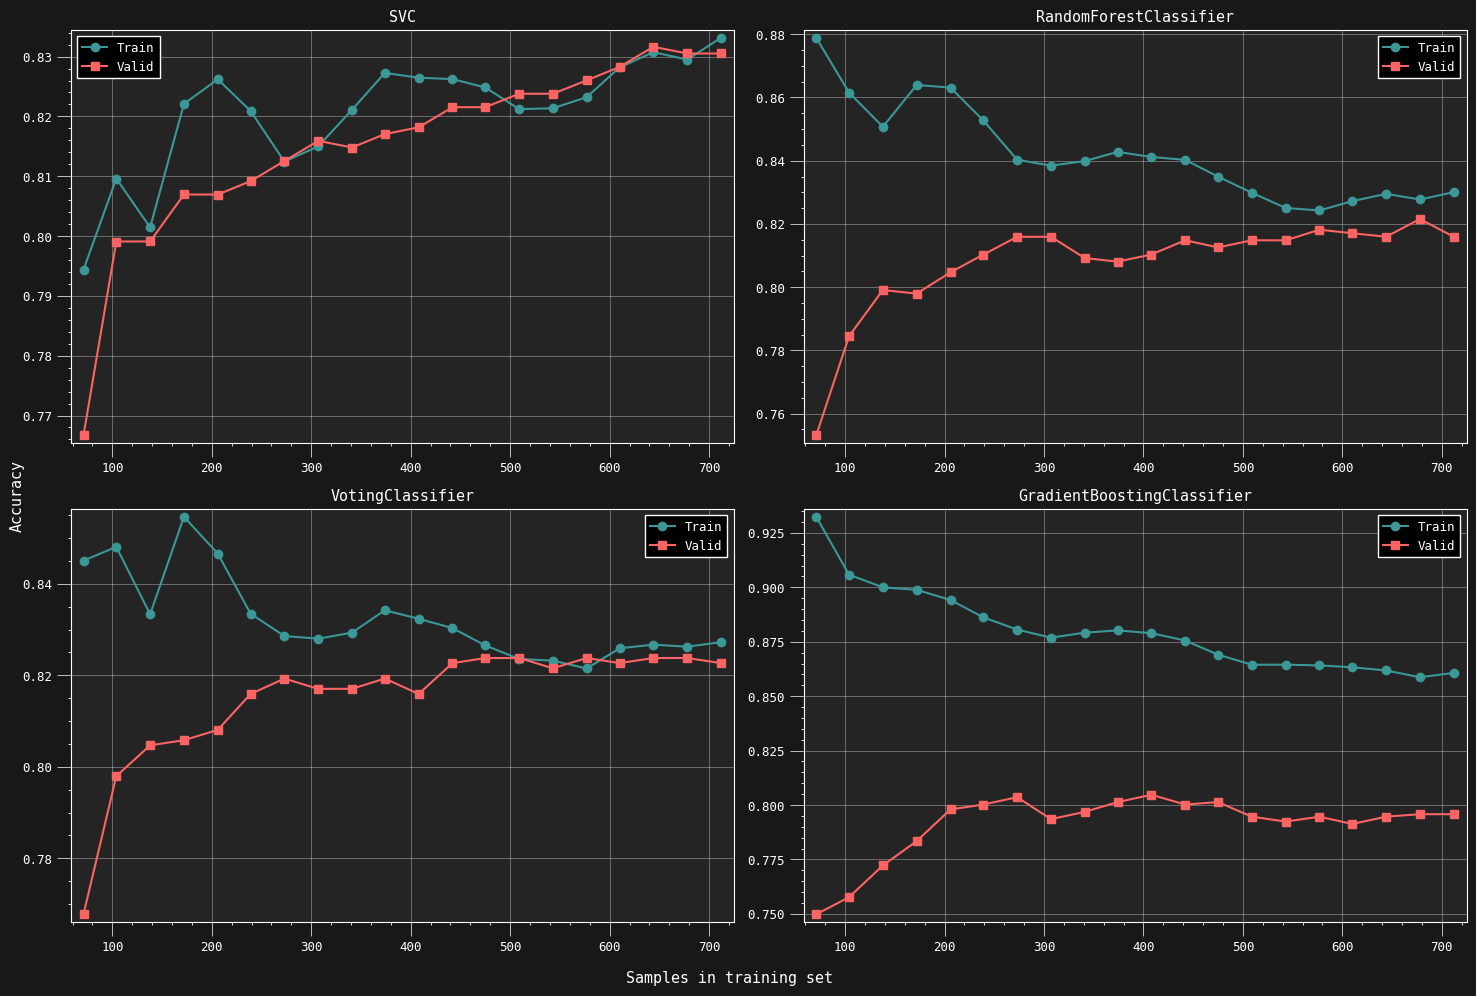

In [59]:
# Remove prefixes from best_params_
rfc_best_params = {k.split("__")[-1]: v for k, v in rfc_random_search.best_params_.items()}
lr_best_params = {k.split("__")[-1]: v for k, v in lr_random_search.best_params_.items()}
gbc_best_params = {k.split("__")[-1]: v for k, v in gbc_random_search.best_params_.items()}

svc_model = SVC()
rfc_model = RandomForestClassifier(**rfc_best_params)
lr_model = LogisticRegression(**lr_best_params)
gbc_model = GradientBoostingClassifier(**gbc_best_params)

voting_clf_model = VotingClassifier(
    estimators=[
        ('svc', svc_model),
        ('rfc', rfc_model),
        ('lr', lr_model),
    ]
)

tunned_models_list = [
    (svc_model, "SVC"),
    (rfc_model, "RandomForestClassifier"),
    (voting_clf_model, "VotingClassifier"),
    (gbc_model, "GradientBoostingClassifier"),
]

plot_learning_curves(tunned_models_list,
                     x=x_preproc,
                     y=y,
                     size=20,
                     n_columns=2)

In [ ]:
# Implement better grid search